In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [3]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        # Implement this!
        # the whole of observation could act as state space, and we will map this to action values
        action_values = Q[observation]
        # this gives me action values for all the actions that I can take from this state
        max_value_action = np.argmax(action_values)
        policy = np.empty(nA)
        policy.fill(epsilon / float(nA))
        policy[max_value_action] += 1 - epsilon
        return policy
        
    return policy_fn

In [12]:
def compute_discounted_return(reward_list, discount_factor):
    discounted_rewards = list()
    for i, t in enumerate(reward_list[::-1]):
        if i == 0:
            discounted_rewards.append(t)
        else:
            reward = t + discount_factor * discounted_rewards[-1]
            discounted_rewards.append(reward)
    # return from time 1 to end, right now time 1 is the last element
    return discounted_rewards[::-1]

In [25]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Nubmer of episodes to sample.
        discount_factor: Lambda discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function taht takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)

    for e in range(num_episodes):
        # reset the environment
        if e % 1000 == 0:
            print("\rEpisode {}/{}.".format(e, num_episodes), end="")
            sys.stdout.flush()
        observation = env.reset()
        reward_ = list()
        state_action = list()
        # roll out the episode
        while True:
            # get how to act with the given observation
            action_probs = policy(observation)
            # you have to sample the action from the probs and execute it, we select with prob 1-E  + E/nA the max action
            # toss the coin
            toss = np.random.uniform()
            if toss <= ((1-epsilon) + (epsilon / env.action_space.n)):
                action = np.argmax(action_probs)
            else:
                while True:
                    action = np.random.randint(0, env.action_space.n)
                    if action != np.argmax(action_probs):
                        break
            # save the state action pair
            state_action.append((observation, action))
            # execute the action
            observation, reward, done, _ = env.step(action)
            # save the reward accumulated in the episode
            reward_.append(reward)
            if done:
                # episode is finished update everything
                epsilon = epsilon / (num_episodes+1)
                # compute the discounted return
                discounted_return = compute_discounted_return(reward_, discount_factor)
                # go through each observation action pair increment its count and then shift the value towards the current return
                for i, sap in enumerate(state_action):
                    returns_count[sap] += 1
                    # where sap is the tuple of state action pair
                    Q[sap[0]][sap[1]] = Q[sap[0]][sap[1]] + (1 / returns_count[sap]) * (discounted_return[i] - Q[sap[0]][sap[1]])
                break
    return Q, policy

In [26]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

Episode 499000/500000.

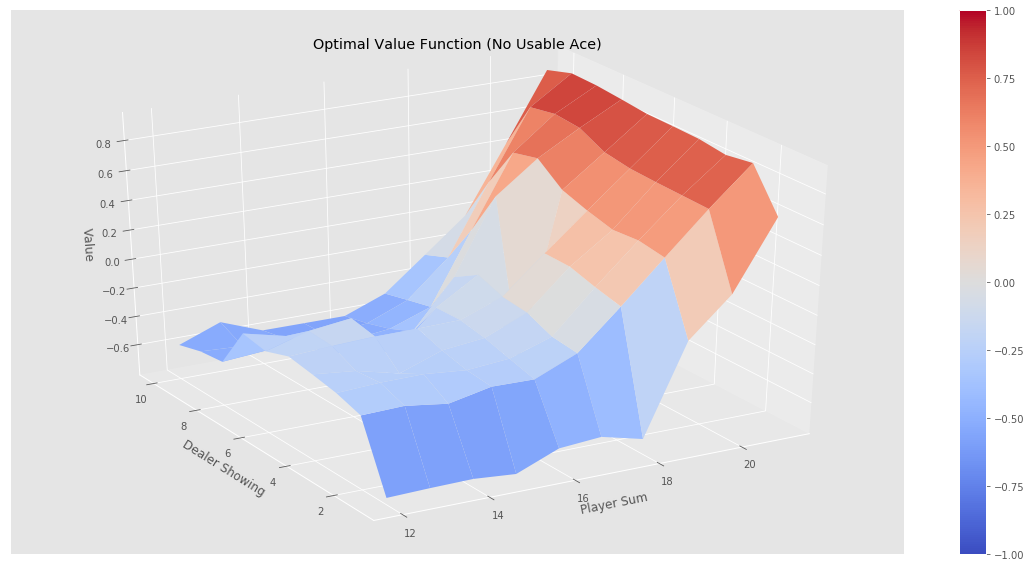

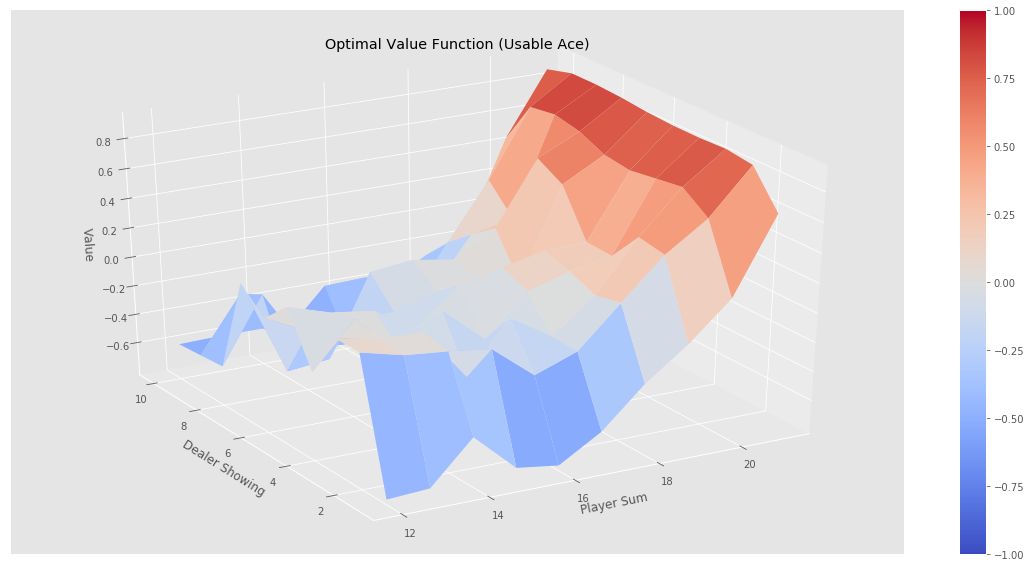

In [27]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")